In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Предсказание погоды на следующий день:
Будет дождь, если rainfall >=1

In [5]:
df = pd.read_csv('/content/drive/MyDrive/lab8/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
df.shape

(145460, 23)

Удалим столбцы

In [7]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Удаление строк с пропущенными значениями

In [8]:
df = df.dropna()
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


Преобразование данных стобца

In [9]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

<ipython-input-9-062454651978>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
<ipython-input-9-062454651978>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
<ipython-input-9-0

In [10]:
df[df['RainTomorrow']==0.0].count()

,0
Rainfall,97103
Humidity3pm,97103
Pressure9am,97103
RainToday,97103
RainTomorrow,97103


In [11]:
df[df['RainTomorrow']==1.0].count()

,0
Rainfall,27586
Humidity3pm,27586
Pressure9am,27586
RainToday,27586
RainTomorrow,27586


Классы несбалансированы

In [12]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Преобразуем в тензор

In [13]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


#NN

In [14]:

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)

    # torch.nn.init.xavier_uniform_(self.fc1.weight)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [15]:
criterion = nn.BCELoss()

In [16]:
device = torch.device( "cpu")

In [17]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [18]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [ ]:
net = Net(4)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
net = net.to(device)

criterion = criterion.to(device)

for epoch in range(2000):

    train_loss = 0
    y_pred = net(X_train)

    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    if epoch % 100 == 0:

          y_test_pred = net(X_test)
          y_test_pred = torch.squeeze(y_test_pred)

          test_loss = criterion(y_test_pred, y_test)

          test_acc = calculate_accuracy(y_test, y_test_pred)
          print(
    f'''epoch {epoch}
    Test  set - loss: {test_loss}, accuracy: {test_acc}
    ''')

epoch 0
    Test  set - loss: 7.164628505706787, accuracy: 0.2216697335243225
    
epoch 100
    Test  set - loss: 0.5720739960670471, accuracy: 0.7959740161895752
    
epoch 200
    Test  set - loss: 0.5436038970947266, accuracy: 0.7788916230201721
    
epoch 300
    Test  set - loss: 0.5333548188209534, accuracy: 0.7793327569961548
    
epoch 400
    Test  set - loss: 0.5154792666435242, accuracy: 0.7796936631202698
    
epoch 500
    Test  set - loss: 0.48074424266815186, accuracy: 0.7794530391693115
    
epoch 600
    Test  set - loss: 0.46781307458877563, accuracy: 0.7808966040611267
    
epoch 700
    Test  set - loss: 0.4557693302631378, accuracy: 0.784866452217102
    
epoch 800
    Test  set - loss: 0.44445592164993286, accuracy: 0.7911219596862793
    
epoch 900
    Test  set - loss: 0.4336666762828827, accuracy: 0.7984601855278015
    
epoch 1000
    Test  set - loss: 0.4242238998413086, accuracy: 0.8103296160697937
    
epoch 1100
    Test  set - loss: 0.4171040952205658, a

In [ ]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

In [ ]:
net = torch.load(MODEL_PATH)

<ipython-input-20-58455d427580>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(MODEL_PATH)


In [ ]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.79      0.68      0.71     24938
weighted avg       0.83      0.84      0.82     24938



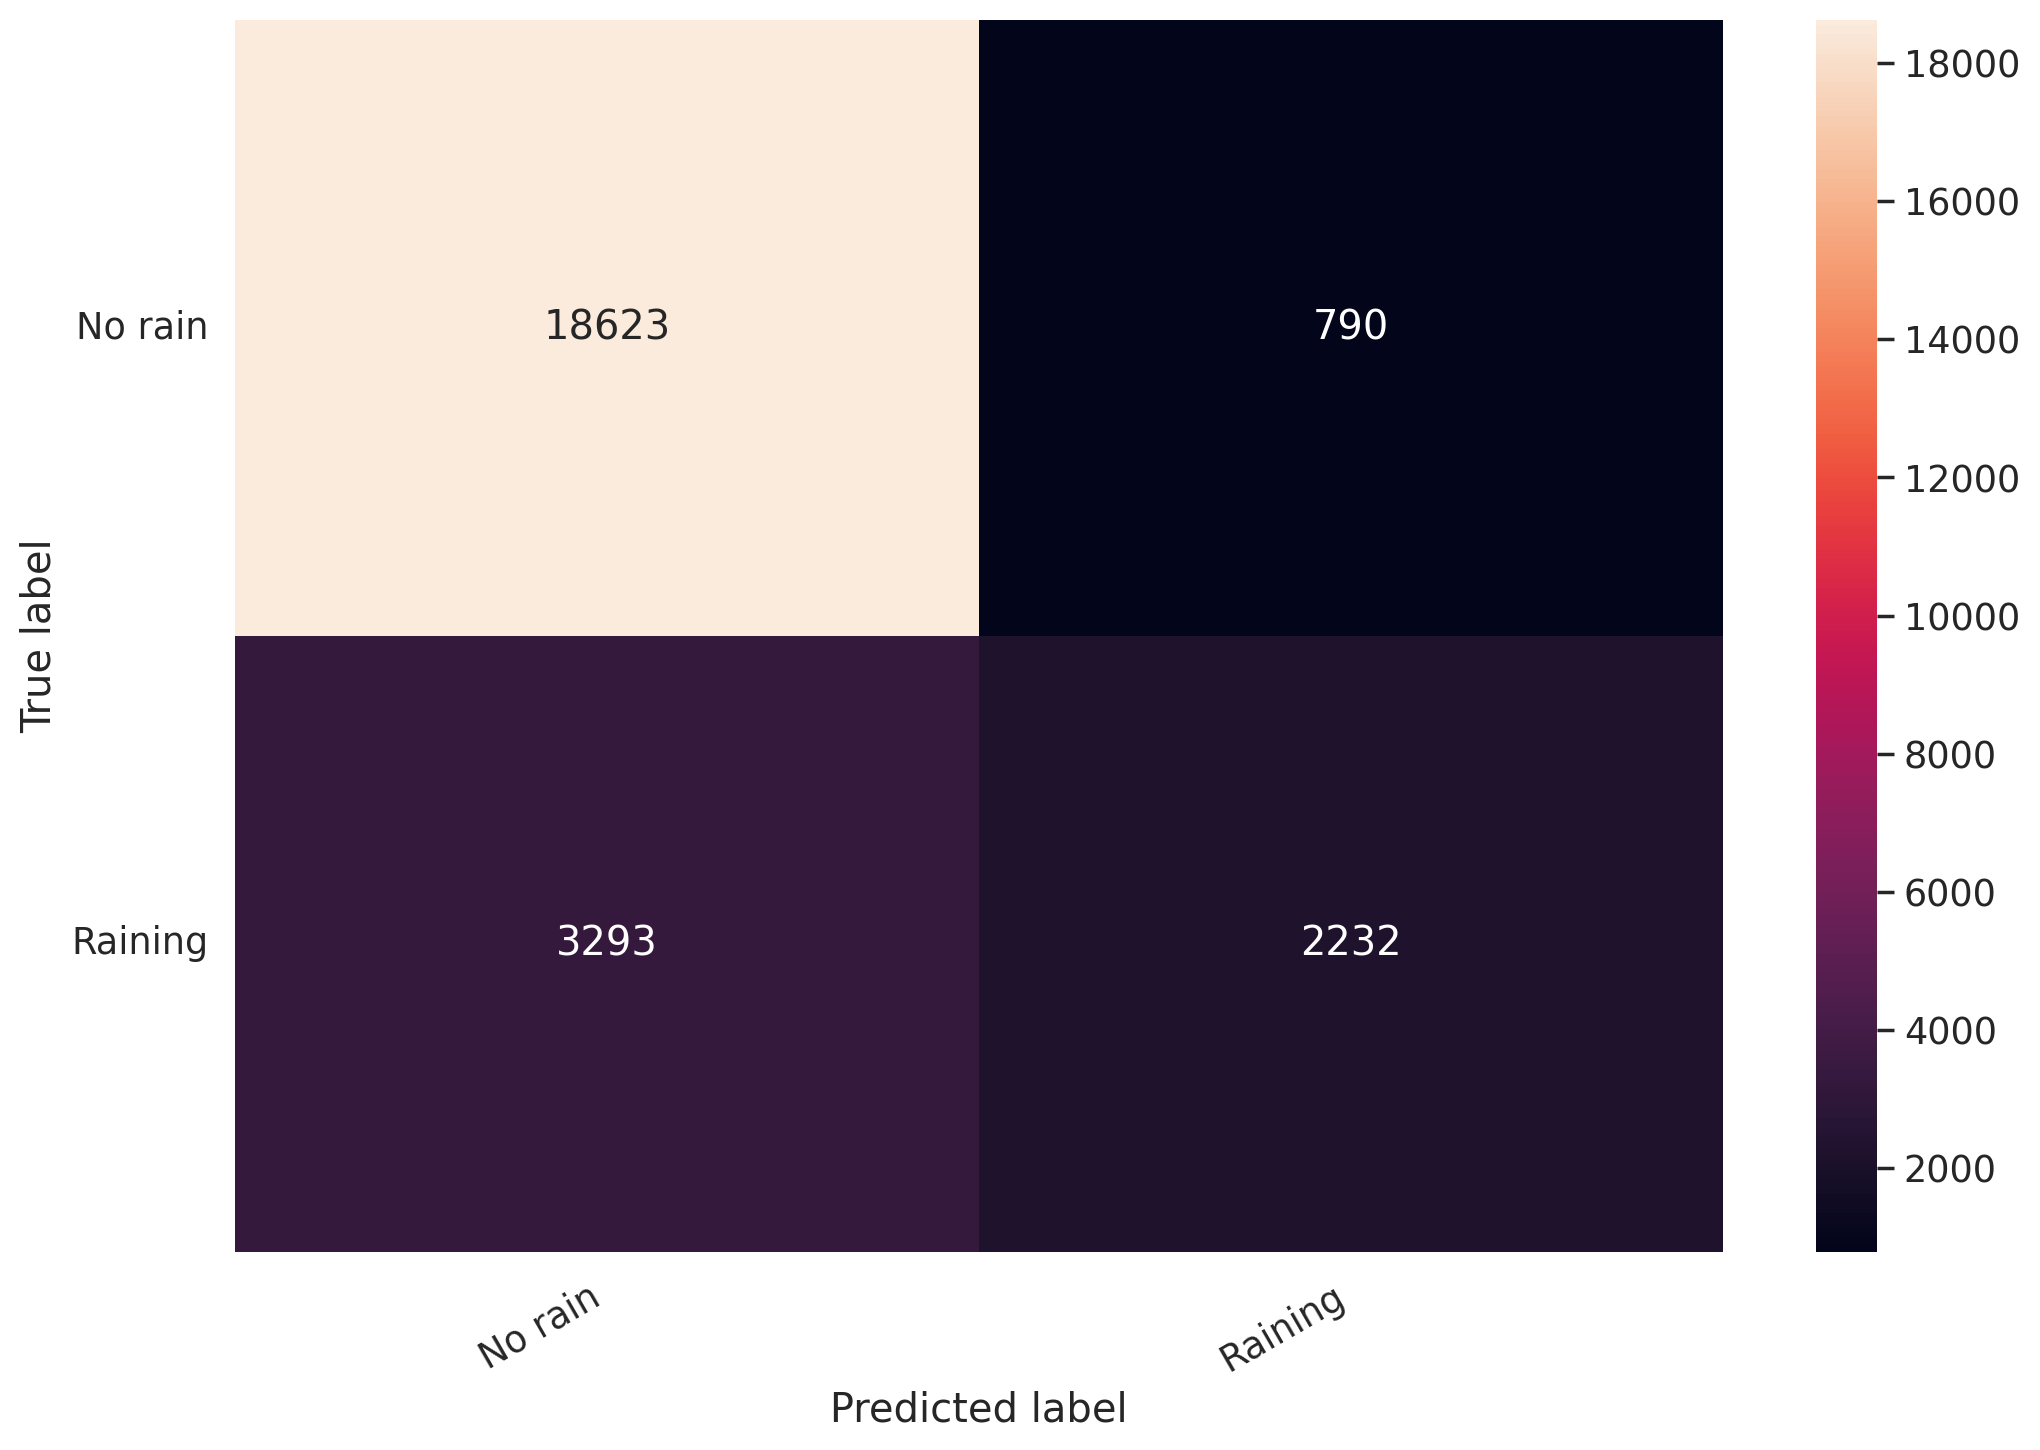

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
# 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate,
# выберите оптимальное значение.

# 2. Примените нормализацию данных. Исследуйте скорость сходимости.

# 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя, Удаления/добавления нейронов в каждом слое.

# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html

# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

# Обучение сети

In [42]:
def train_net(net = Net(4), epochs=2000, lerning_rate=0.0001, print_every=100, criterion=nn.BCELoss(), optimizer=None):
    # net = Net(4)
    if not optimizer:
        optimizer = optim.Adam(net.parameters(), lr=lerning_rate)

    net = net.to(device)

    criterion = criterion.to(device)

    losses = []

    for epoch in range(epochs):

        train_loss = 0
        y_pred = net(X_train)

        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

        losses.append(train_loss.tolist())

        if epoch % print_every == 0:

              y_test_pred = net(X_test)
              y_test_pred = torch.squeeze(y_test_pred)

              test_loss = criterion(y_test_pred, y_test)

              test_acc = calculate_accuracy(y_test, y_test_pred)
              print(
        f'''epoch {epoch}
        lr: {lerning_rate} | loss: {test_loss:.4f}, accuracy: {test_acc:.4f}
        ''')

    return losses

In [20]:
device = torch.device( "cpu")

In [21]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [22]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

#1 Сходимость в зависимости от learning rate

In [ ]:
# 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate,
# выберите оптимальное значение.

epoch 0
        lr: 0.1 | loss: 0.5979, accuracy: 0.7785
        
epoch 999
        lr: 0.1 | loss: 0.5289, accuracy: 0.7785
        
epoch 0
        lr: 0.01 | loss: 77.8451, accuracy: 0.2215
        
epoch 999
        lr: 0.01 | loss: 77.8451, accuracy: 0.2215
        
epoch 0
        lr: 0.001 | loss: 9.9487, accuracy: 0.7785
        
epoch 999
        lr: 0.001 | loss: 0.4136, accuracy: 0.8200
        
epoch 0
        lr: 0.0001 | loss: 8.6807, accuracy: 0.7785
        
epoch 999
        lr: 0.0001 | loss: 0.4819, accuracy: 0.7851
        
epoch 0
        lr: 1e-05 | loss: 0.8564, accuracy: 0.2215
        
epoch 999
        lr: 1e-05 | loss: 0.8487, accuracy: 0.2215
        


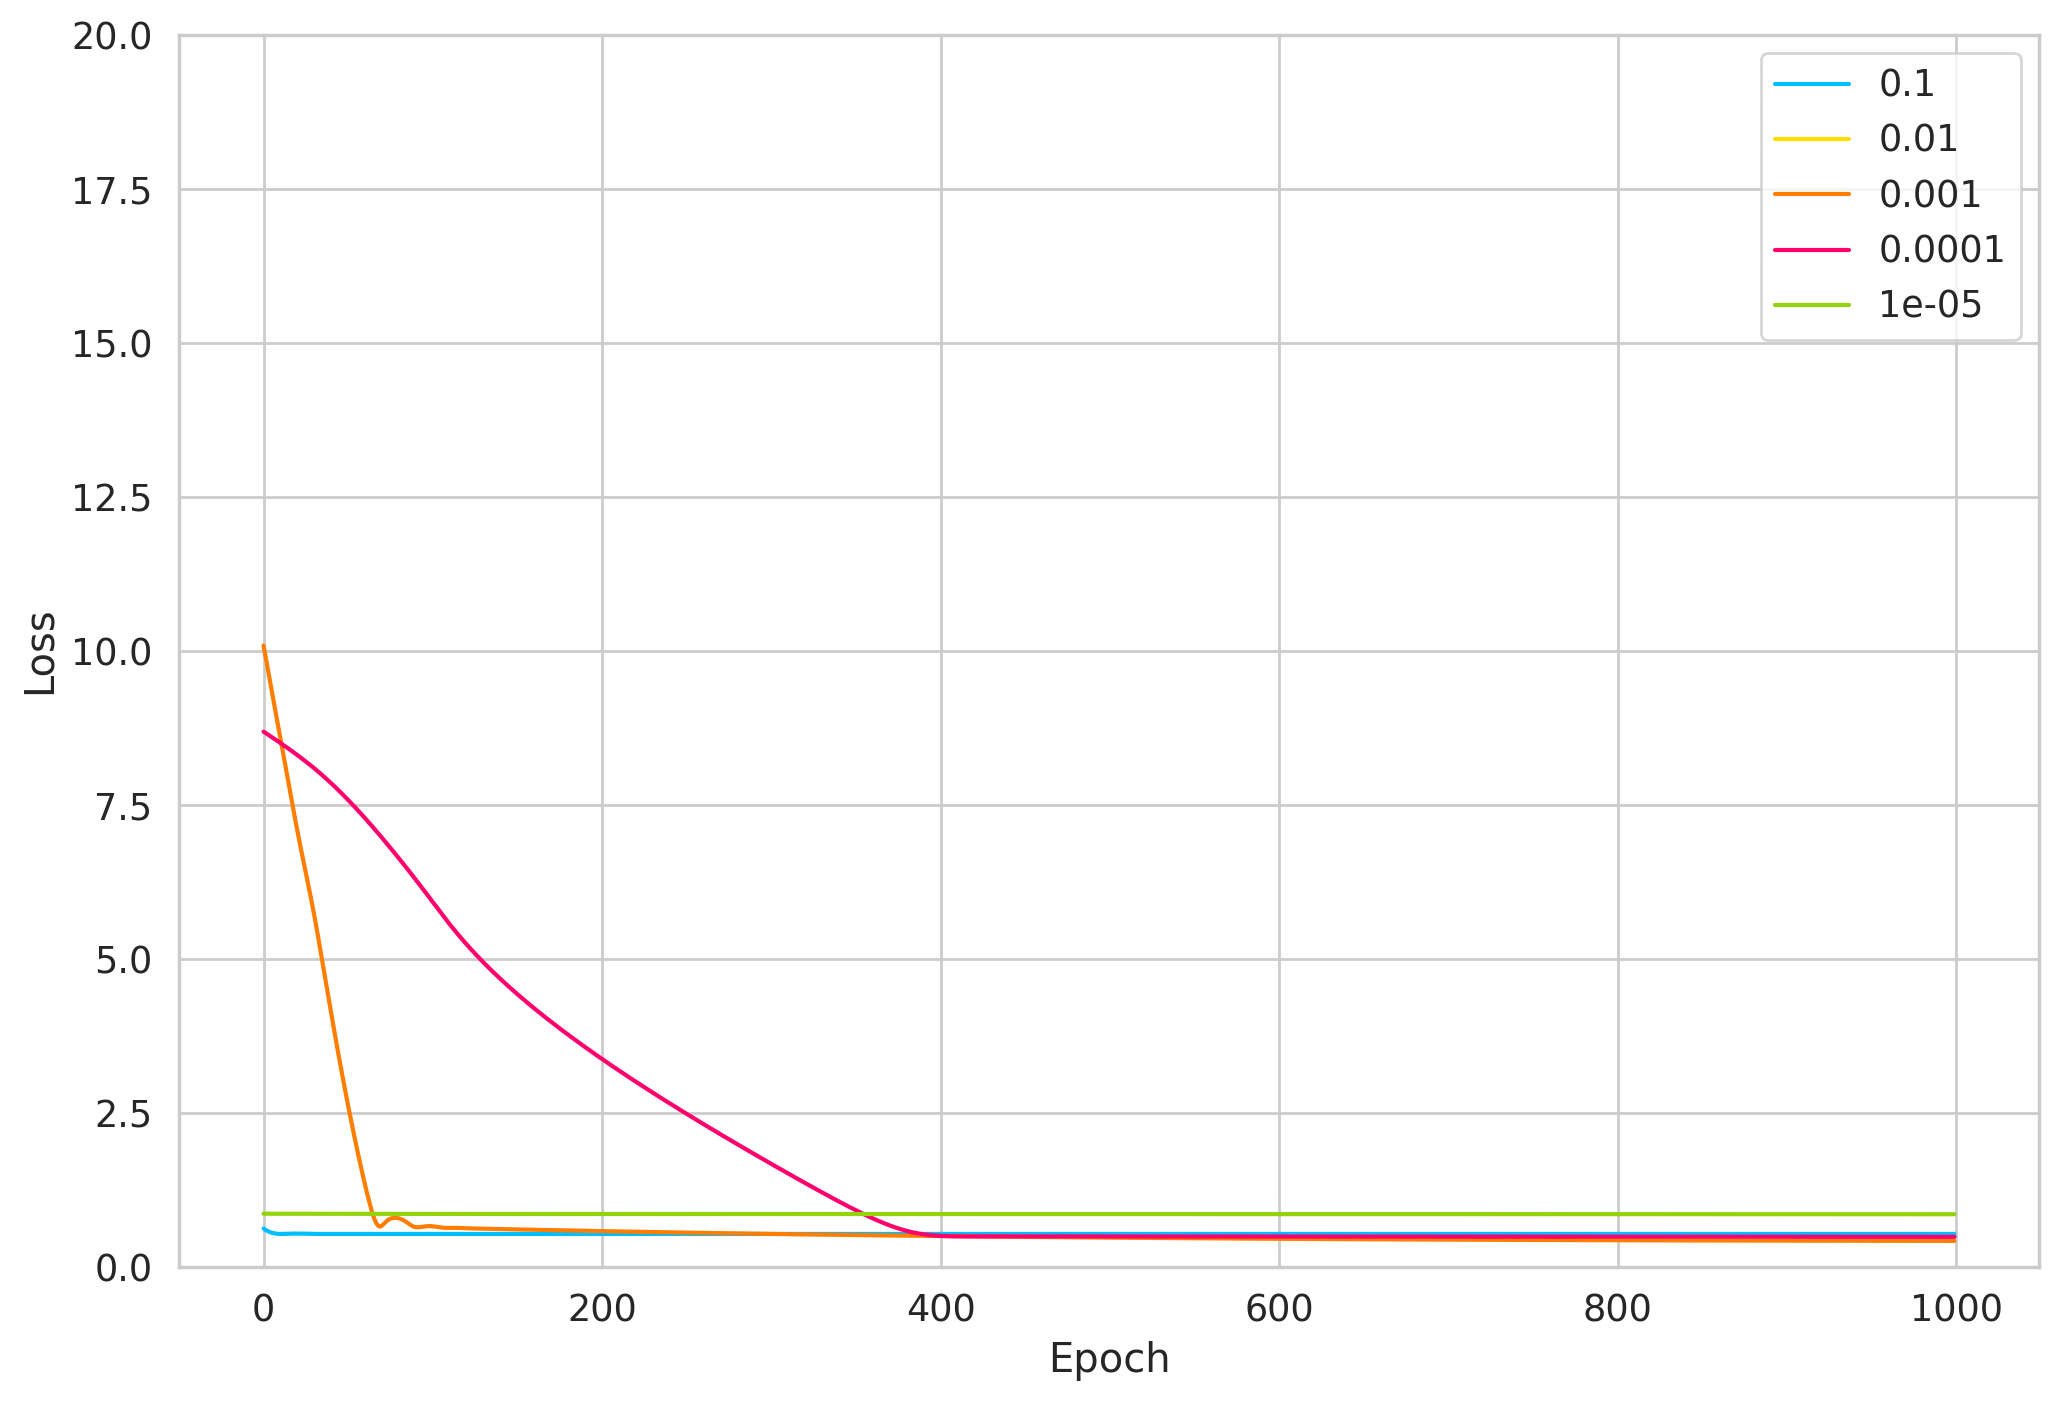

In [ ]:
learning_rates = [10 ** (-i)  for i in range(1, 6)]

ax = plt.gca()

for lr in learning_rates:
    losses = train_net(lerning_rate=lr, print_every=999, epochs=1000)

    ax.plot(losses, label=str(lr))
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.set_ylim([0, 20])
plt.legend()
plt.show()

#2 Скорость сходимости при нормализации данных

In [ ]:
# 2. Примените нормализацию данных. Исследуйте скорость сходимости.

In [23]:
from sklearn.preprocessing import StandardScaler

X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=RANDOM_SEED)

X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

epoch 0
        lr: 0.001 | loss: 0.7707, accuracy: 0.2215
        
epoch 999
        lr: 0.001 | loss: 0.3746, accuracy: 0.8422
        


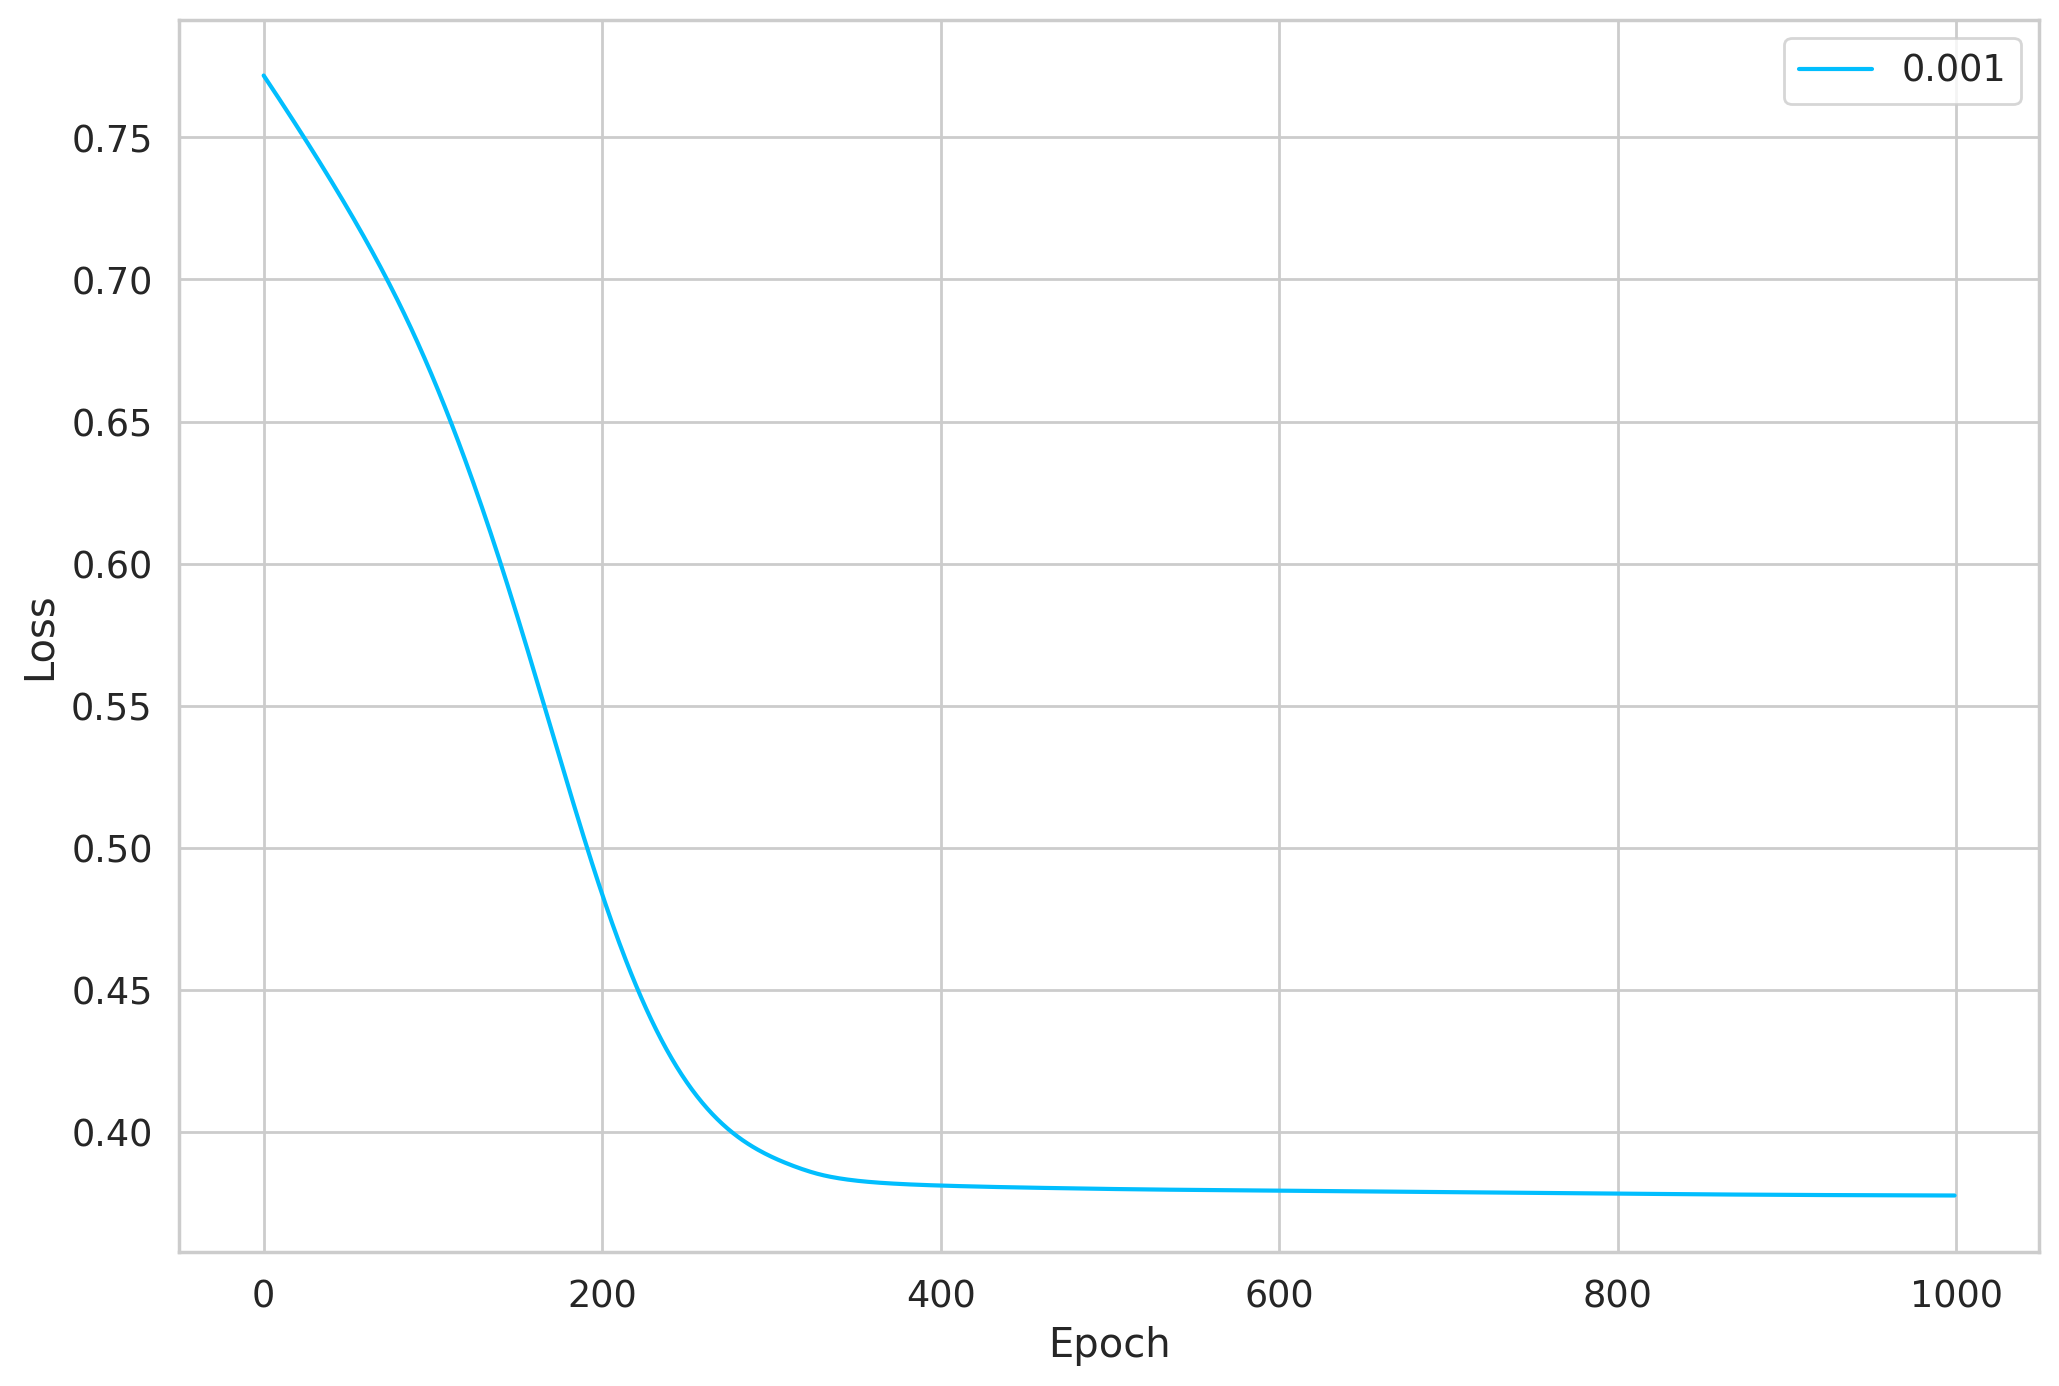

In [ ]:
losses = train_net(lerning_rate=0.001, print_every=999, epochs=1000)

plt.plot(losses, label='0.001')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#3 Изменение структуры сети

In [ ]:
# 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя, Удаления/добавления нейронов в каждом слое.

In [24]:

class CustomNet(nn.Module):

  def __init__(self, n_features, layers):
      super(CustomNet, self).__init__()

      self.layer1 = layers[0]
      self.fc1 = nn.Linear(n_features, layers[0])
      self.fc2_end = nn.Linear(layers[0], 1)

      self.layer2 = layers[1]
      self.fc2 = nn.Linear(layers[0], layers[1])
      self.fc3_end =  nn.Linear(layers[1], 1)

      self.layer3 = layers[2]
      self.fc3 = nn.Linear(layers[1], layers[2])
      self.fc4_end = nn.Linear(layers[2], 1)


      # torch.nn.init.xavier_uniform_(self.fc1.weight)

  def forward(self, x):
      x = F.relu(self.fc1(x))

      if not self.layer2:
          return torch.sigmoid(self.fc2_end(x))
      x = F.relu(self.fc2(x))

      if not self.layer3:
          return torch.sigmoid(self.fc3_end(x))
      x = F.relu(self.fc3(x))

      return torch.sigmoid(self.fc4_end(x))

In [27]:
layers = {"1 layer - 8": [8, 0, 0],
          "1 layer - 4": [4, 0, 0],
          "1 layer - 16": [16, 0, 0],
          "2 layer - 8, 4": [8, 4, 0],
          "2 layer - 4, 2": [4, 2, 0],
          "2 layer - 16, 8": [16, 8, 0],
          "2 layer - 8, 16": [8, 16, 0],
          "3 layer - 8, 4, 2": [8, 4, 2],
          "3 layer - 16, 8, 4": [16, 8, 4],
          "3 layer - 4, 2, 1": [4, 2, 1],
          "3 layer - 8, 4, 8": [8, 4, 8],
          "3 layer - 8, 16, 8": [8, 16, 8],
          }


all_losses = []

for name, param in layers.items():

    print(str(name))
    net_ = CustomNet(4, param)
    losses = train_net(
        net=net_,
        epochs=1000,
        lerning_rate=0.001,
        print_every=999)

    all_losses.append(losses)

1 layer - 8
epoch 0
        lr: 0.001 | loss: 0.7761, accuracy: 0.2741
        


/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


epoch 999
        lr: 0.001 | loss: 0.3761, accuracy: 0.8414
        
1 layer - 4
epoch 0
        lr: 0.001 | loss: 0.6652, accuracy: 0.7024
        
epoch 999
        lr: 0.001 | loss: 0.3797, accuracy: 0.8410
        
1 layer - 16
epoch 0
        lr: 0.001 | loss: 0.6568, accuracy: 0.7181
        
epoch 999
        lr: 0.001 | loss: 0.3741, accuracy: 0.8426
        
2 layer - 8, 4
epoch 0
        lr: 0.001 | loss: 0.8065, accuracy: 0.2215
        
epoch 999
        lr: 0.001 | loss: 0.3747, accuracy: 0.8425
        
2 layer - 4, 2
epoch 0
        lr: 0.001 | loss: 0.6238, accuracy: 0.7785
        
epoch 999
        lr: 0.001 | loss: 0.4597, accuracy: 0.8412
        
2 layer - 16, 8
epoch 0
        lr: 0.001 | loss: 0.7355, accuracy: 0.2180
        
epoch 999
        lr: 0.001 | loss: 0.3741, accuracy: 0.8428
        
2 layer - 8, 16
epoch 0
        lr: 0.001 | loss: 0.6909, accuracy: 0.5539
        
epoch 999
        lr: 0.001 | loss: 0.3738, accuracy: 0.8422
        
3 layer - 8, 4,

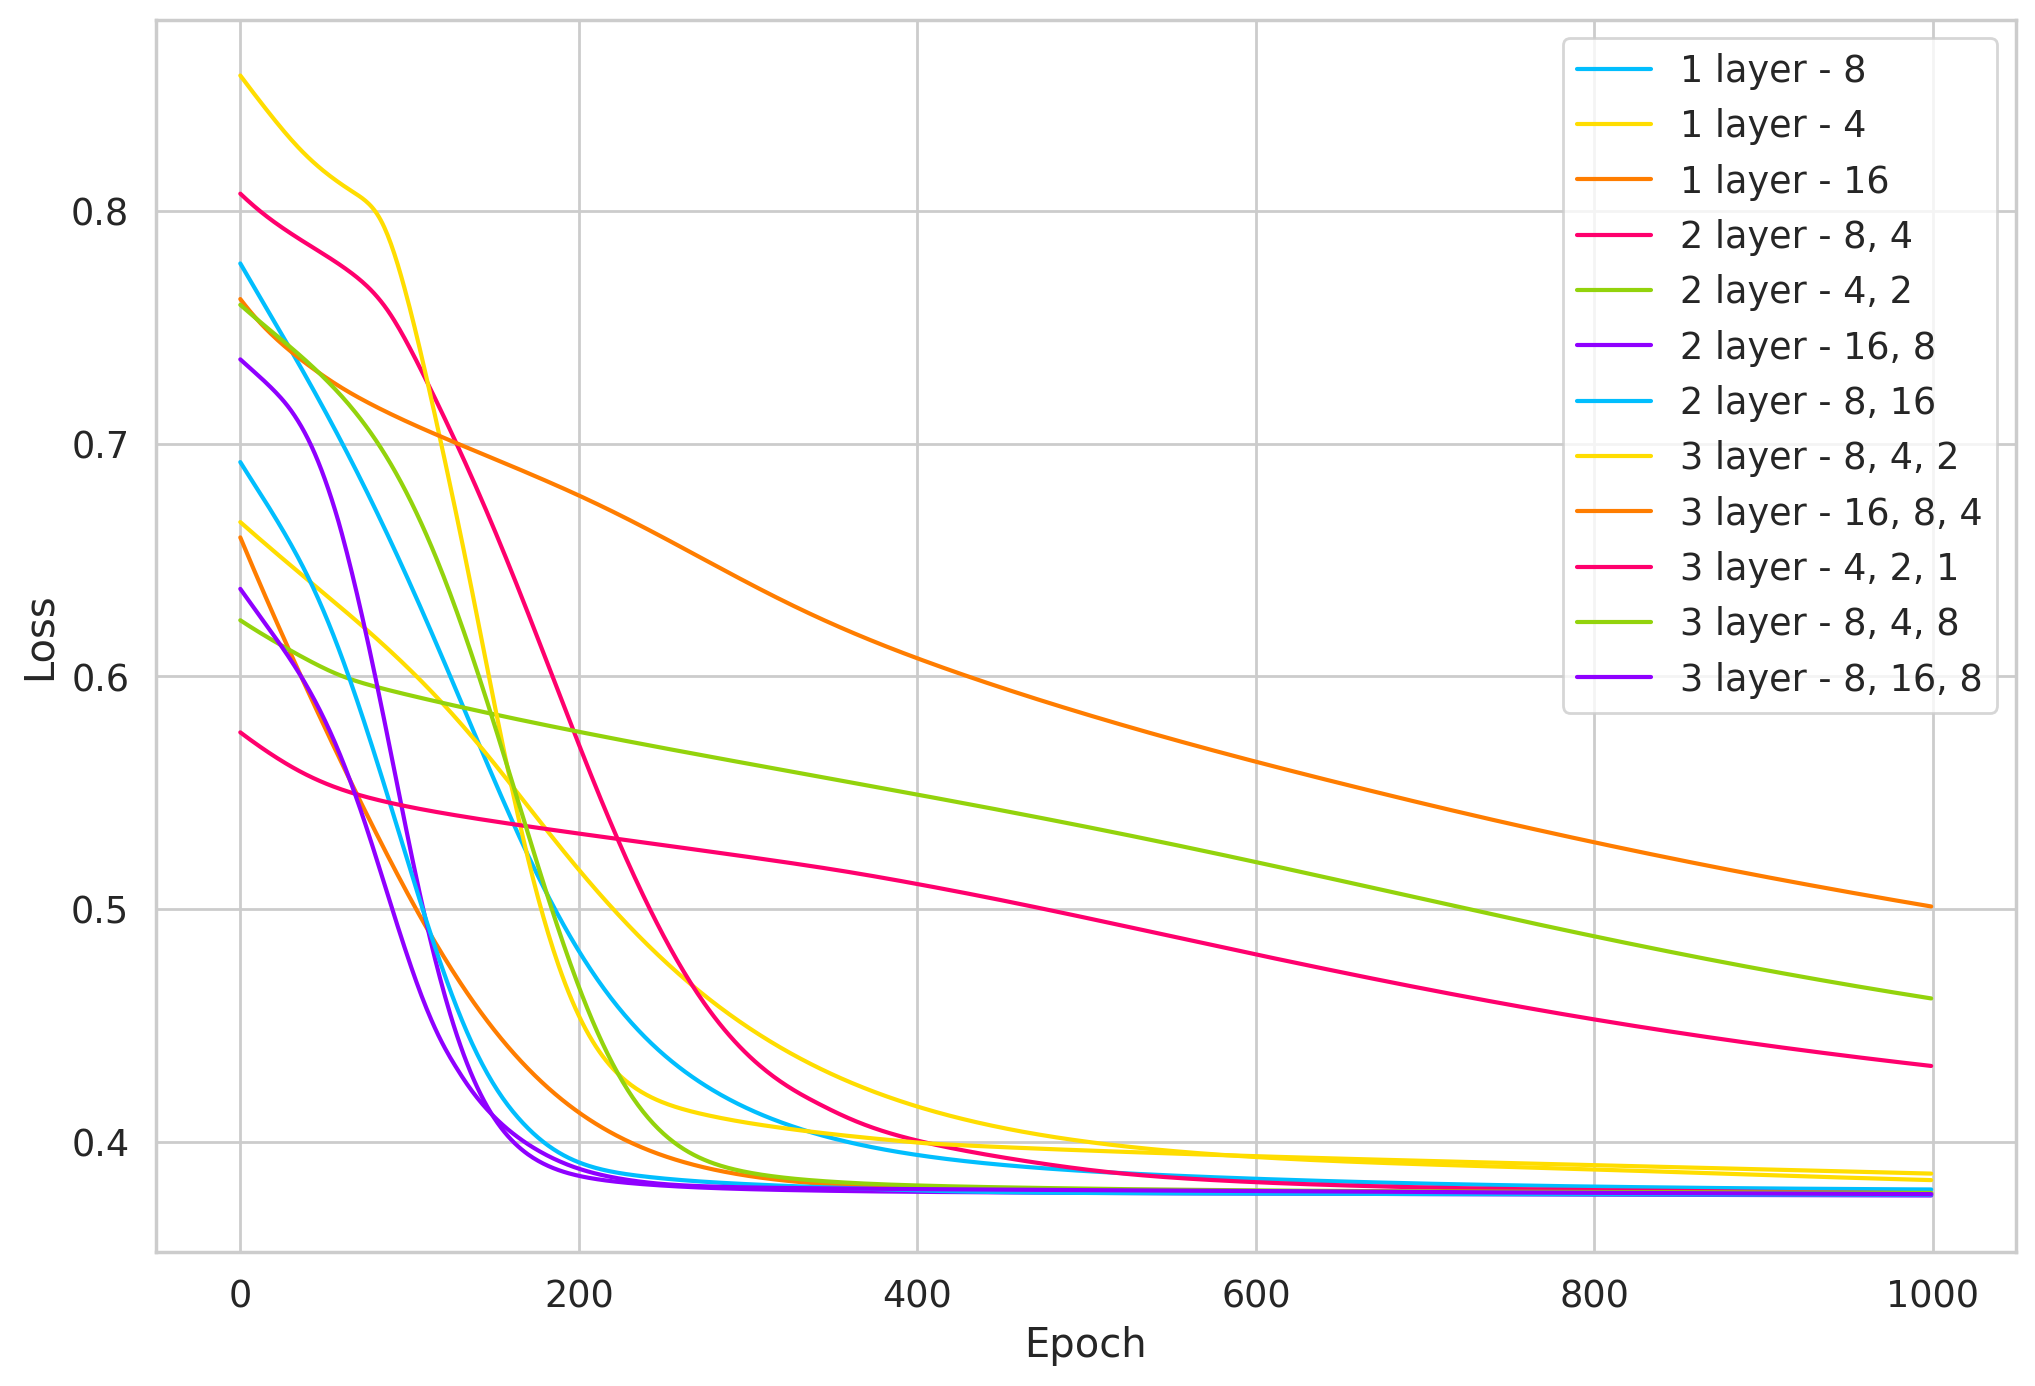

In [38]:
for i, name in enumerate(layers.keys(), start=0):
    plt.plot(all_losses[i], label=str(name))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#4 Скорость сходимости от функции активации

In [ ]:
# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

In [39]:
class CustomActivateNet(nn.Module):

    def __init__(self, n_features, func):
        super(CustomActivateNet, self).__init__()
        self.fc1 = nn.Linear(n_features, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)
        self.activate = func

        # torch.nn.init.xavier_uniform_(self.fc1.weight)

    def forward(self, x):
        x = self.activate(self.fc1(x))
        x = self.activate(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [40]:
functions = {'relu': F.relu,
             'hardtanh' : F.hardtanh,
             'sigmoid': F.sigmoid,
             'softplus': F.softplus,
             }

all_losses = []

for name, function in functions.items():

    print(str(name))
    net_ = CustomActivateNet(4, function)
    losses = train_net(
        net=net_,
        epochs=1000,
        lerning_rate=0.001,
        print_every=999)

    all_losses.append(losses)

relu
epoch 0
        lr: 0.001 | loss: 0.6419, accuracy: 0.7785
        
epoch 999
        lr: 0.001 | loss: 0.3745, accuracy: 0.8423
        
hardtanh
epoch 0
        lr: 0.001 | loss: 0.6473, accuracy: 0.7636
        
epoch 999
        lr: 0.001 | loss: 0.3783, accuracy: 0.8421
        
sigmoid
epoch 0
        lr: 0.001 | loss: 0.7558, accuracy: 0.2215
        
epoch 999
        lr: 0.001 | loss: 0.4381, accuracy: 0.7785
        
softplus
epoch 0
        lr: 0.001 | loss: 0.7024, accuracy: 0.2261
        
epoch 999
        lr: 0.001 | loss: 0.3799, accuracy: 0.8411
        


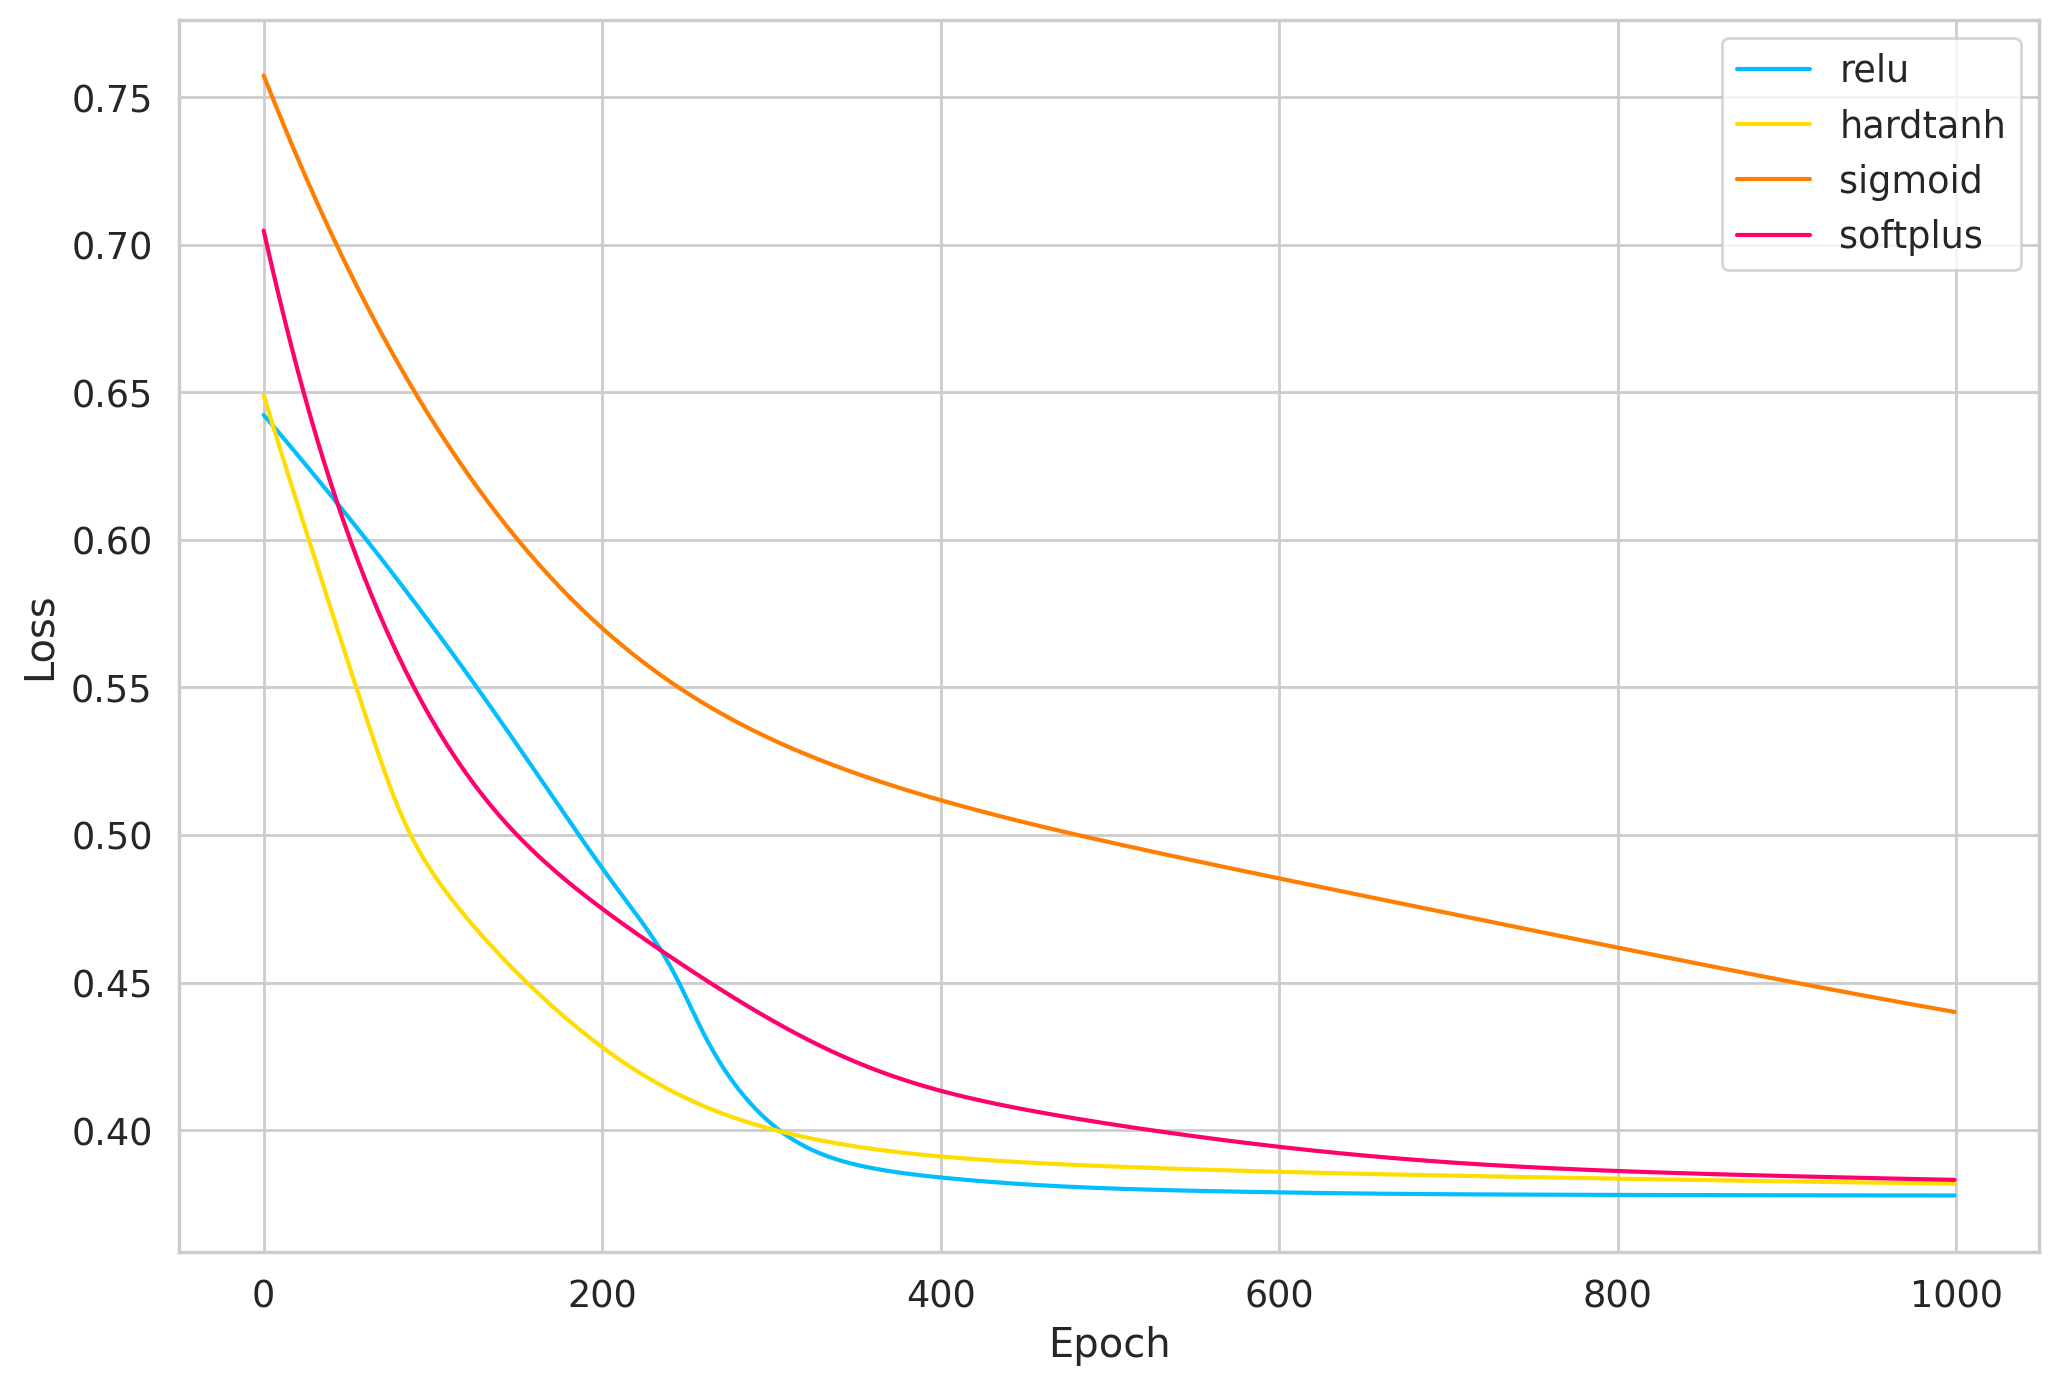

In [41]:
for i, name in enumerate(functions.keys(), start=0):
    plt.plot(all_losses[i], label=str(name))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#5 Скорость сходимости от метода оптимизации

In [ ]:
# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html

In [43]:
optimizers = {
    'Adam': lambda x: optim.Adam(x, lr=0.001),
    'NAdam' : lambda x: optim.NAdam(x, lr=0.001),
    'SGD': lambda x: optim.SGD(x, lr=0.001),
    'Adamax': lambda x: optim.Adamax(x, lr=0.001),
    }

all_losses = []

for name, optimizer in optimizers.items():

    print(str(name))
    net_ = Net(4)
    losses = train_net(
        net=net_,
        optimizer=optimizer(net_.parameters()),
        epochs=1000,
        lerning_rate=0.001,
        print_every=999)

    all_losses.append(losses)

Adam
epoch 0
        lr: 0.001 | loss: 0.7656, accuracy: 0.2215
        
epoch 999
        lr: 0.001 | loss: 0.3744, accuracy: 0.8429
        
NAdam
epoch 0
        lr: 0.001 | loss: 0.7687, accuracy: 0.2215
        
epoch 999
        lr: 0.001 | loss: 0.3744, accuracy: 0.8421
        
SGD
epoch 0
        lr: 0.001 | loss: 0.6102, accuracy: 0.7785
        
epoch 999
        lr: 0.001 | loss: 0.5794, accuracy: 0.7785
        
Adamax
epoch 0
        lr: 0.001 | loss: 0.7571, accuracy: 0.2215
        
epoch 999
        lr: 0.001 | loss: 0.3763, accuracy: 0.8414
        


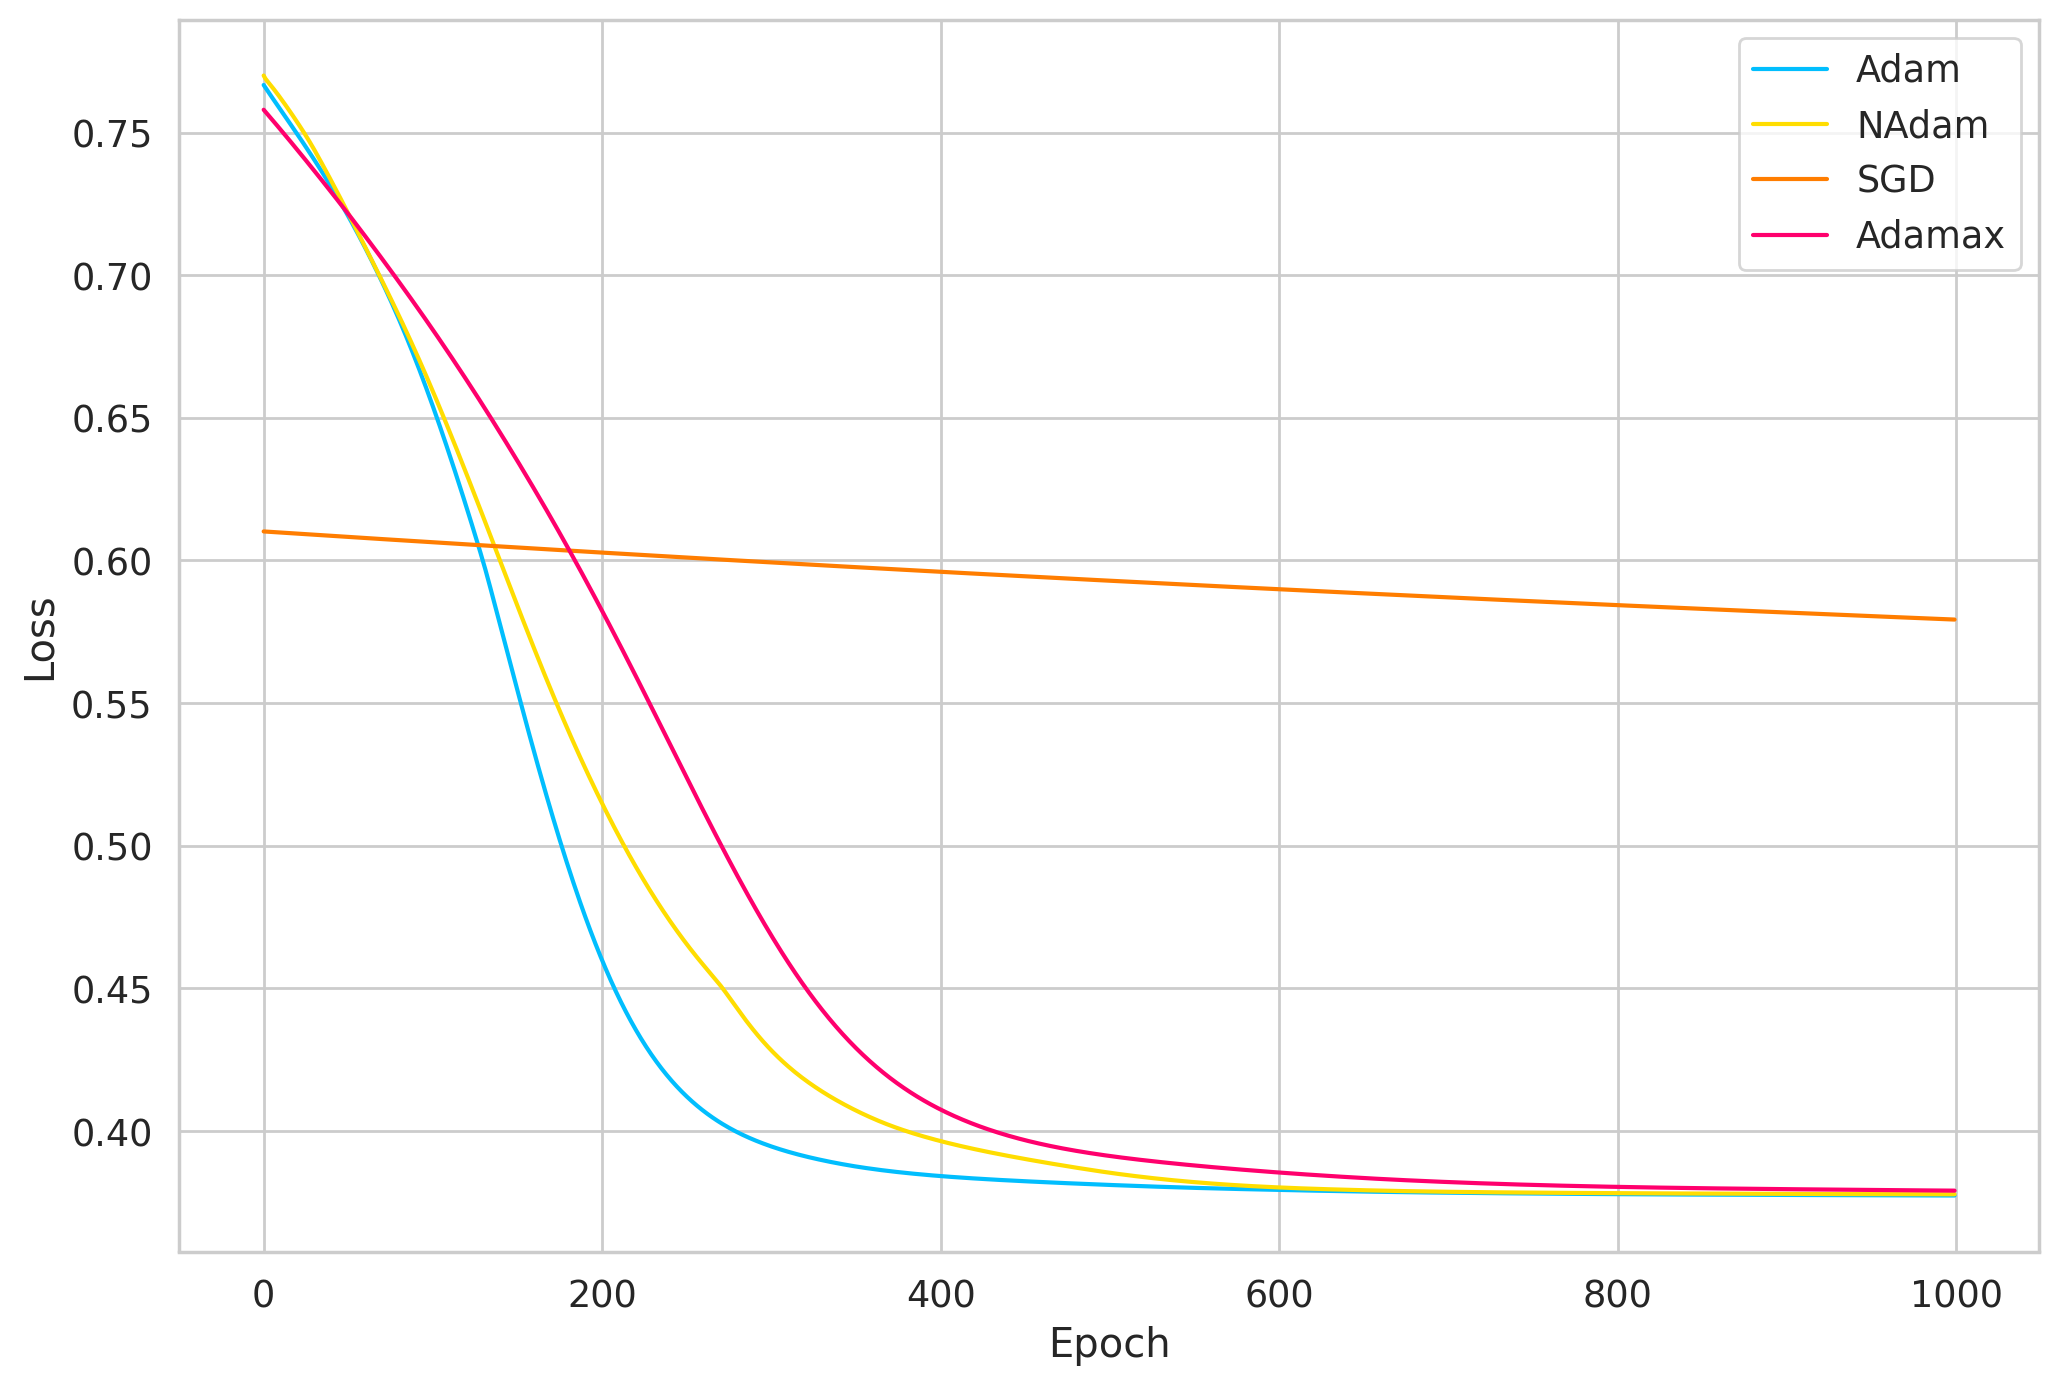

In [44]:
for i, name in enumerate(optimizers.keys(), start=0):
    plt.plot(all_losses[i], label=str(name))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#6 Скорость сходимости от начальной инициализации весов

In [ ]:
# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

In [46]:
def init_weights_x(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

def init_weights_k(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)

functions = {
    "Default": None,
    "Xavier": init_weights_x,
    "Kaiming": init_weights_k
}

for name, func in functions.items():
    print(str(name))

    net_ = Net(4).to(device)
    if func:
        net_.apply(func)
    optimizer_ = optim.Adam(net_.parameters(), lr=0.001)

    losses = train_net(
        net=net_,
        optimizer=optimizer_,
        epochs=1000,
        lerning_rate=0.001,
        print_every=999)

    all_losses.append(losses)

Default
epoch 0
        lr: 0.001 | loss: 0.6933, accuracy: 0.4637
        
epoch 999
        lr: 0.001 | loss: 0.3927, accuracy: 0.8408
        
Xavier
epoch 0
        lr: 0.001 | loss: 0.6893, accuracy: 0.4878
        


<ipython-input-46-514cac8900a9>:3: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


epoch 999
        lr: 0.001 | loss: 0.3753, accuracy: 0.8419
        
Kaiming
epoch 0
        lr: 0.001 | loss: 0.8499, accuracy: 0.3550
        
epoch 999
        lr: 0.001 | loss: 0.3792, accuracy: 0.8419
        


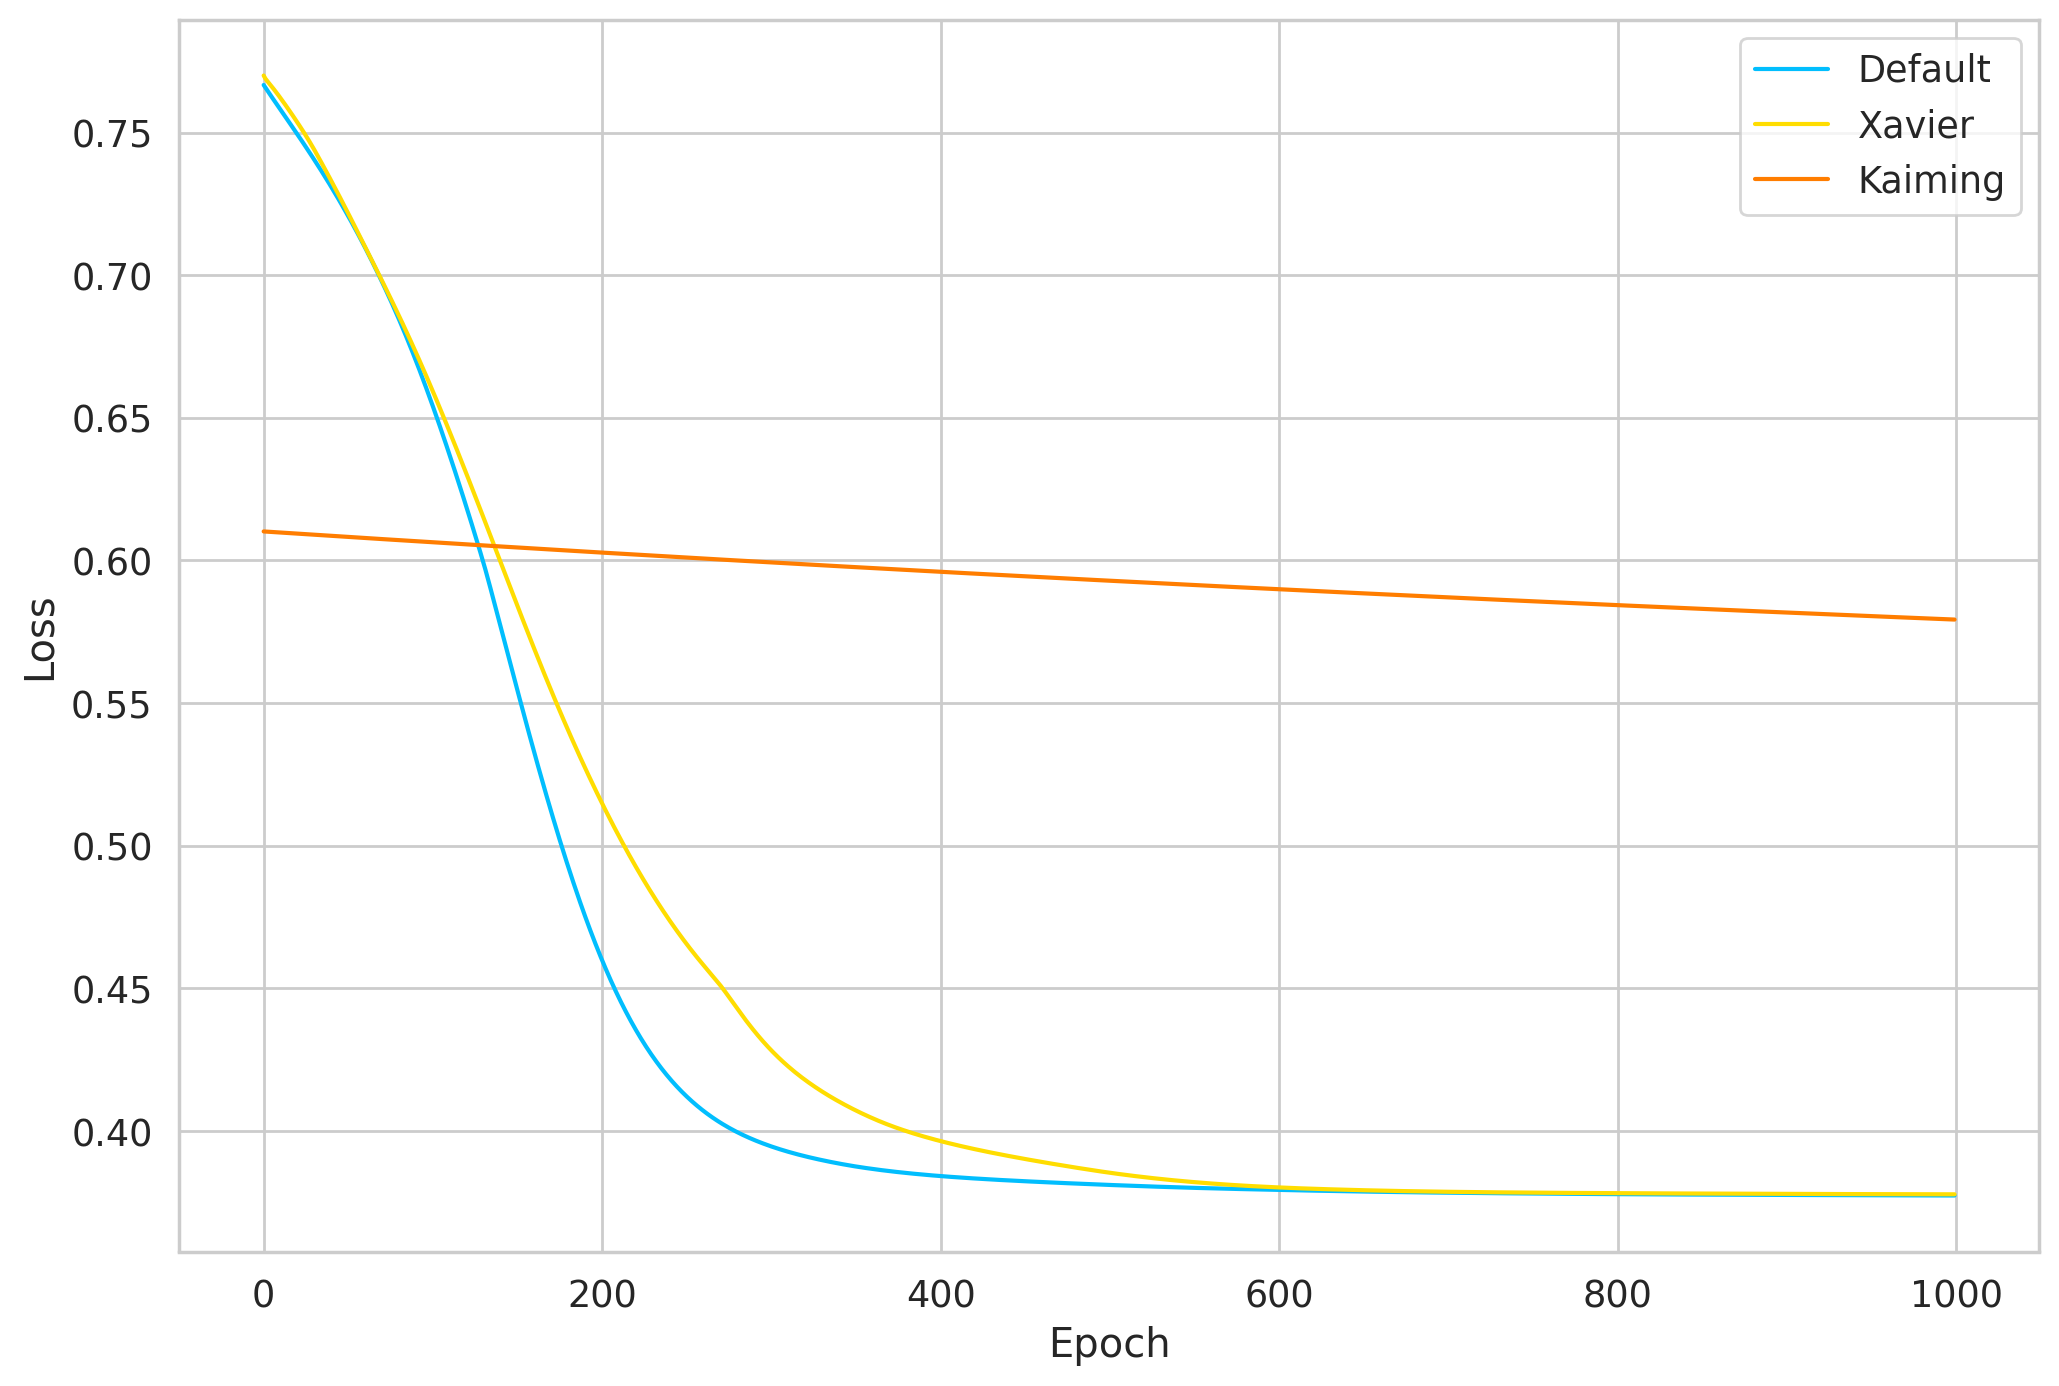

In [47]:
for i, name in enumerate(functions.keys(), start=0):
    plt.plot(all_losses[i], label=str(name))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()